<h1> Statistical Analysis of Rental cars & Exploring suitable ML models </h1>

<h4> Author: Gyo-Jin Kang </h4>

<h3> Introduction </h3>

<div>
<img src="190325-rental-cars-cs-229p.jpg" width="400"/>
<img src="download.jpg" width="500"/>
</div>

<p> Who doesn't enjoy a well-planned and thrilling family trip? The number of families who travel to different areas to explore new places and create valuable memories with their families have been increasing over the years with a huge development of transportation (Uber, Taxi, cars, trains, etc..). One of the biggest problems that many face is renting a car. Whether or not you are travelling to a local place or outside of the country, without cars, exploring the environment becomes exponentially difficult. However, the varying prices and quality of cars especially tend to affect the quality of our travel as poor car maintenance, design, quality or rental cars being too expensive can interfere with our enjoyment. Therefore, it becomes a good idea to use statistics to analyze the information about rental cars and use ML to explore Regression models and make predictions. </p>

<h3> Future Question:</h3>
<p> How do the prices of rental cars vary for different categories -- Rating, number of reviews, mileage travelled? </p>

<h3> The Data: </h3>
<p> The data that we are using is from a popular car rental site, "Cars.com". However, an API or a CSV file is non-existent. Hence, I am using the BeautifulSoup library to webscrape a good-quality data from the website itself. </p>

<h5> Required Imports </h5>
<p> Pandas, Seaborn and Matplotlib are used to visualize and wrangle data. The bs4 import and requests are used for requesting and parsing HTML file into CSV file for future data analysis. 
Lastly, sci-kit learn libraries from feature_selection, ensemble, linear_model, metrics and model_selection are imported. These are strictly for implementing Regression, optimizing the ML model, and assessing its accuracy. </p>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

<h5> Dataframe Preparation </h5>
<p> To store the information webscraped using Beautifulsoup and store it into a dataframe, we create the dataframe and lists that act as columns. </p>

In [3]:
car_names = []#
prices = []#
ratings = []#
reviews = []#
used_mi = []#
locations = []#
price_drops = []
deals = []#
model = []

df = pd.DataFrame()

Below is the Cars.com URL that we are requesting the HTML data from. The Header dictionary includes the User-Agent element, which allows us to bypass any web-restrictions.

In [58]:
URL = "https://www.cars.com/shopping/results/?dealer_id=&keyword=&list_price_max=&list_price_min=&maximum_distance=all&mileage_max=&monthly_payment=&page=1&page_size=20&sort=best_match_desc&stock_type=cpo&year_max=&year_min=&zip="

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US, en;q=0.5",
}

We then create a function ```get_soup()``` to handle requests as well as any errors that come from fetching wrong data using a try-catch. The request response is fed into the Beautifulsoup object to be parsed into a valid HTML element that we can break down.

In [59]:
def get_soup(url):
    try:
        response = requests.get(url, HEADERS)
    except:
        print("Unable to fetch!")
        pass
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

The ```scrape_car_data()``` function uses the Beautifulsoup function ```.find()``` to get all the relevant HTML elements and its content. Then, we store that into corresponding lists that we created at the start.

In [60]:
def scrape_car_data(url) -> None:
    soup = get_soup(url)
    
    all_cards = soup.find_all("div", class_="vehicle-card")
    
    for d in all_cards:
        car_name = d.find("h2", class_="title").get_text()
        mileage = d.find("div", class_="mileage").get_text()
        price = d.find("span", class_="primary-price").text
        price_change = d.find("span", attrs={"data-qa": "price-drop"})
        deal = d.find("span", class_="sds-badge__label").text.strip()
        review = d.find("span", class_="sds-rating__count")
        review_count = d.find("span", class_="test1")
        location = d.find("div", class_="miles-from").get_text().strip()
        car_model = d.find("p", class_="stock-type").get_text()
        
        car_names.append(car_name)
        prices.append(price)
        if review is not None:
            ratings.append(review.text.strip())
        else:
            ratings.append(0)
        if review_count is not None:
            reviews.append(review_count.text.strip())
        else:
            reviews.append("0")
        locations.append(location)
        used_mi.append(mileage)
        if price_change is not None:
            price_drops.append(price_change.text.strip())
        else:
            price_drops.append("0")
        deals.append(deal)
        model.append(car_model)
    pass

```scrape_car_data()``` fetches the HTML data for the corresponding page. However, we need lots of more data to get a "good-quality" data. A "good-quality" data contains various columns and column types as well as an organized list of relevant information. Hence, we should webscrape multiple pages using ```scrape_next_page()```. ```scrape_next_page()``` implements ```scrape_car_data()``` as ```scrape_next_page()``` constructs a new URL based on the root URL + the next page's link attributes. Hence, ```the scrape_car_data()``` is able to fetch the next page with the new URL.

In [61]:
def scrape_next_page(url):
    s = get_soup(url=url)
    pages = s.find("div", class_="sds-pagination__controls")
    next_btn = pages.find("a", attrs={"aria-label": "Next page"})
    if not next_btn:
        return
    else:
        href = next_btn['href']
        new_url = url + href
        
    return scrape_car_data(new_url)

Finally, we run a for-loop to scrape 200 (num_page) different pages for the website. The success messages indicate completed fetching process.

In [62]:
def scrape_pages(num_page, url) -> None:
    if num_page == 1:
            scrape_car_data(url)
    else:
        for i in range(1, num_page+1):
            scrape_next_page(url)
            print(f"Successfully scraped page: {i}.")
    pass

scrape_pages(200, URL)

Successfully scraped page: 1.
Successfully scraped page: 2.
Successfully scraped page: 3.
Successfully scraped page: 4.
Successfully scraped page: 5.
Successfully scraped page: 6.
Successfully scraped page: 7.
Successfully scraped page: 8.
Successfully scraped page: 9.
Successfully scraped page: 10.
Successfully scraped page: 11.
Successfully scraped page: 12.
Successfully scraped page: 13.
Successfully scraped page: 14.
Successfully scraped page: 15.
Successfully scraped page: 16.
Successfully scraped page: 17.
Successfully scraped page: 18.
Successfully scraped page: 19.
Successfully scraped page: 20.
Successfully scraped page: 21.
Successfully scraped page: 22.
Successfully scraped page: 23.
Successfully scraped page: 24.
Successfully scraped page: 25.
Successfully scraped page: 26.
Successfully scraped page: 27.
Successfully scraped page: 28.
Successfully scraped page: 29.
Successfully scraped page: 30.
Successfully scraped page: 31.
Successfully scraped page: 32.
Successfully scra

<h5> Data Wrangling & Saving </h5>

<p> Here we name all the columns of the dataframe and assign each lists to it. We wrangle the columns: Price, Reviews, Mileage, Price_change and Deals with .strip() and .split(). Such feature engineering allows us to keep relevant and concise information (Ex. Removing $ from Price, removing "km" from Mileage...).

In [63]:
df["Name"] = car_names
df["Price"] = prices
df["Rating"] = ratings
df["Reviews"] = reviews
df["Mileage"] = used_mi
df["Location"] = locations
df["Price_change"] = price_drops
df["Deals"] = deals
df["Model"] = model

df.reset_index()
df["Price"] = df["Price"].apply(lambda p: int(str(p).strip("$").replace(",", "")))
df["Reviews"] = df["Reviews"].apply(lambda r: r.split(" ")[0].strip("(").replace(",",""))
df["Mileage"] = df["Mileage"].transform(lambda m: m.split(" ")[0].replace(",",""))
df["Price_change"] = df["Price_change"].apply(lambda p: int(p.split(" ")[0].strip("$").replace(",","")))
df["Deals"] = df["Deals"].apply(lambda x: x.split(" |")[0])
# df = df.drop_duplicates()

df.to_csv("car_deals.csv",encoding="utf-8", header=True, index_label="id")

<h2> Exploratory Data Analysis </h2>

First, we read the file using ```.read_csv()``` and use the delimiter as ",". We first explore the basic statistics of the columns as well as its dimensions.

In [4]:
cars = pd.read_csv("./car_deals.csv", sep=",")

# EDAQ
cars.info()
cars.shape
print(cars.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4200 non-null   int64  
 1   Name          4200 non-null   object 
 2   Price         4200 non-null   int64  
 3   Rating        4200 non-null   float64
 4   Reviews       4200 non-null   int64  
 5   Mileage       4200 non-null   int64  
 6   Location      4200 non-null   object 
 7   Price_change  4200 non-null   int64  
 8   Deals         4200 non-null   object 
 9   Model         4200 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 328.2+ KB
                id          Price       Rating      Reviews       Mileage  \
count  4200.000000    4200.000000  4200.000000  4200.000000   4200.000000   
mean   2099.500000   57152.468333     4.144357  1243.355238  22685.189048   
std    1212.579894   40866.374297     1.343302  1429.728546  17525.404283   
min  

<h5> Rating distribution of car models </h5>

<p> The barplot below shows that most cars have high ratings, which is good because if any customers are reting from this site, they are likely to get good quality cars. Bentley, Subaru and Honda are not as high as others. It is surprising that Bentley isn't as high since it is a very expensive car. Price doesn't possibly imply higher rating! </p>

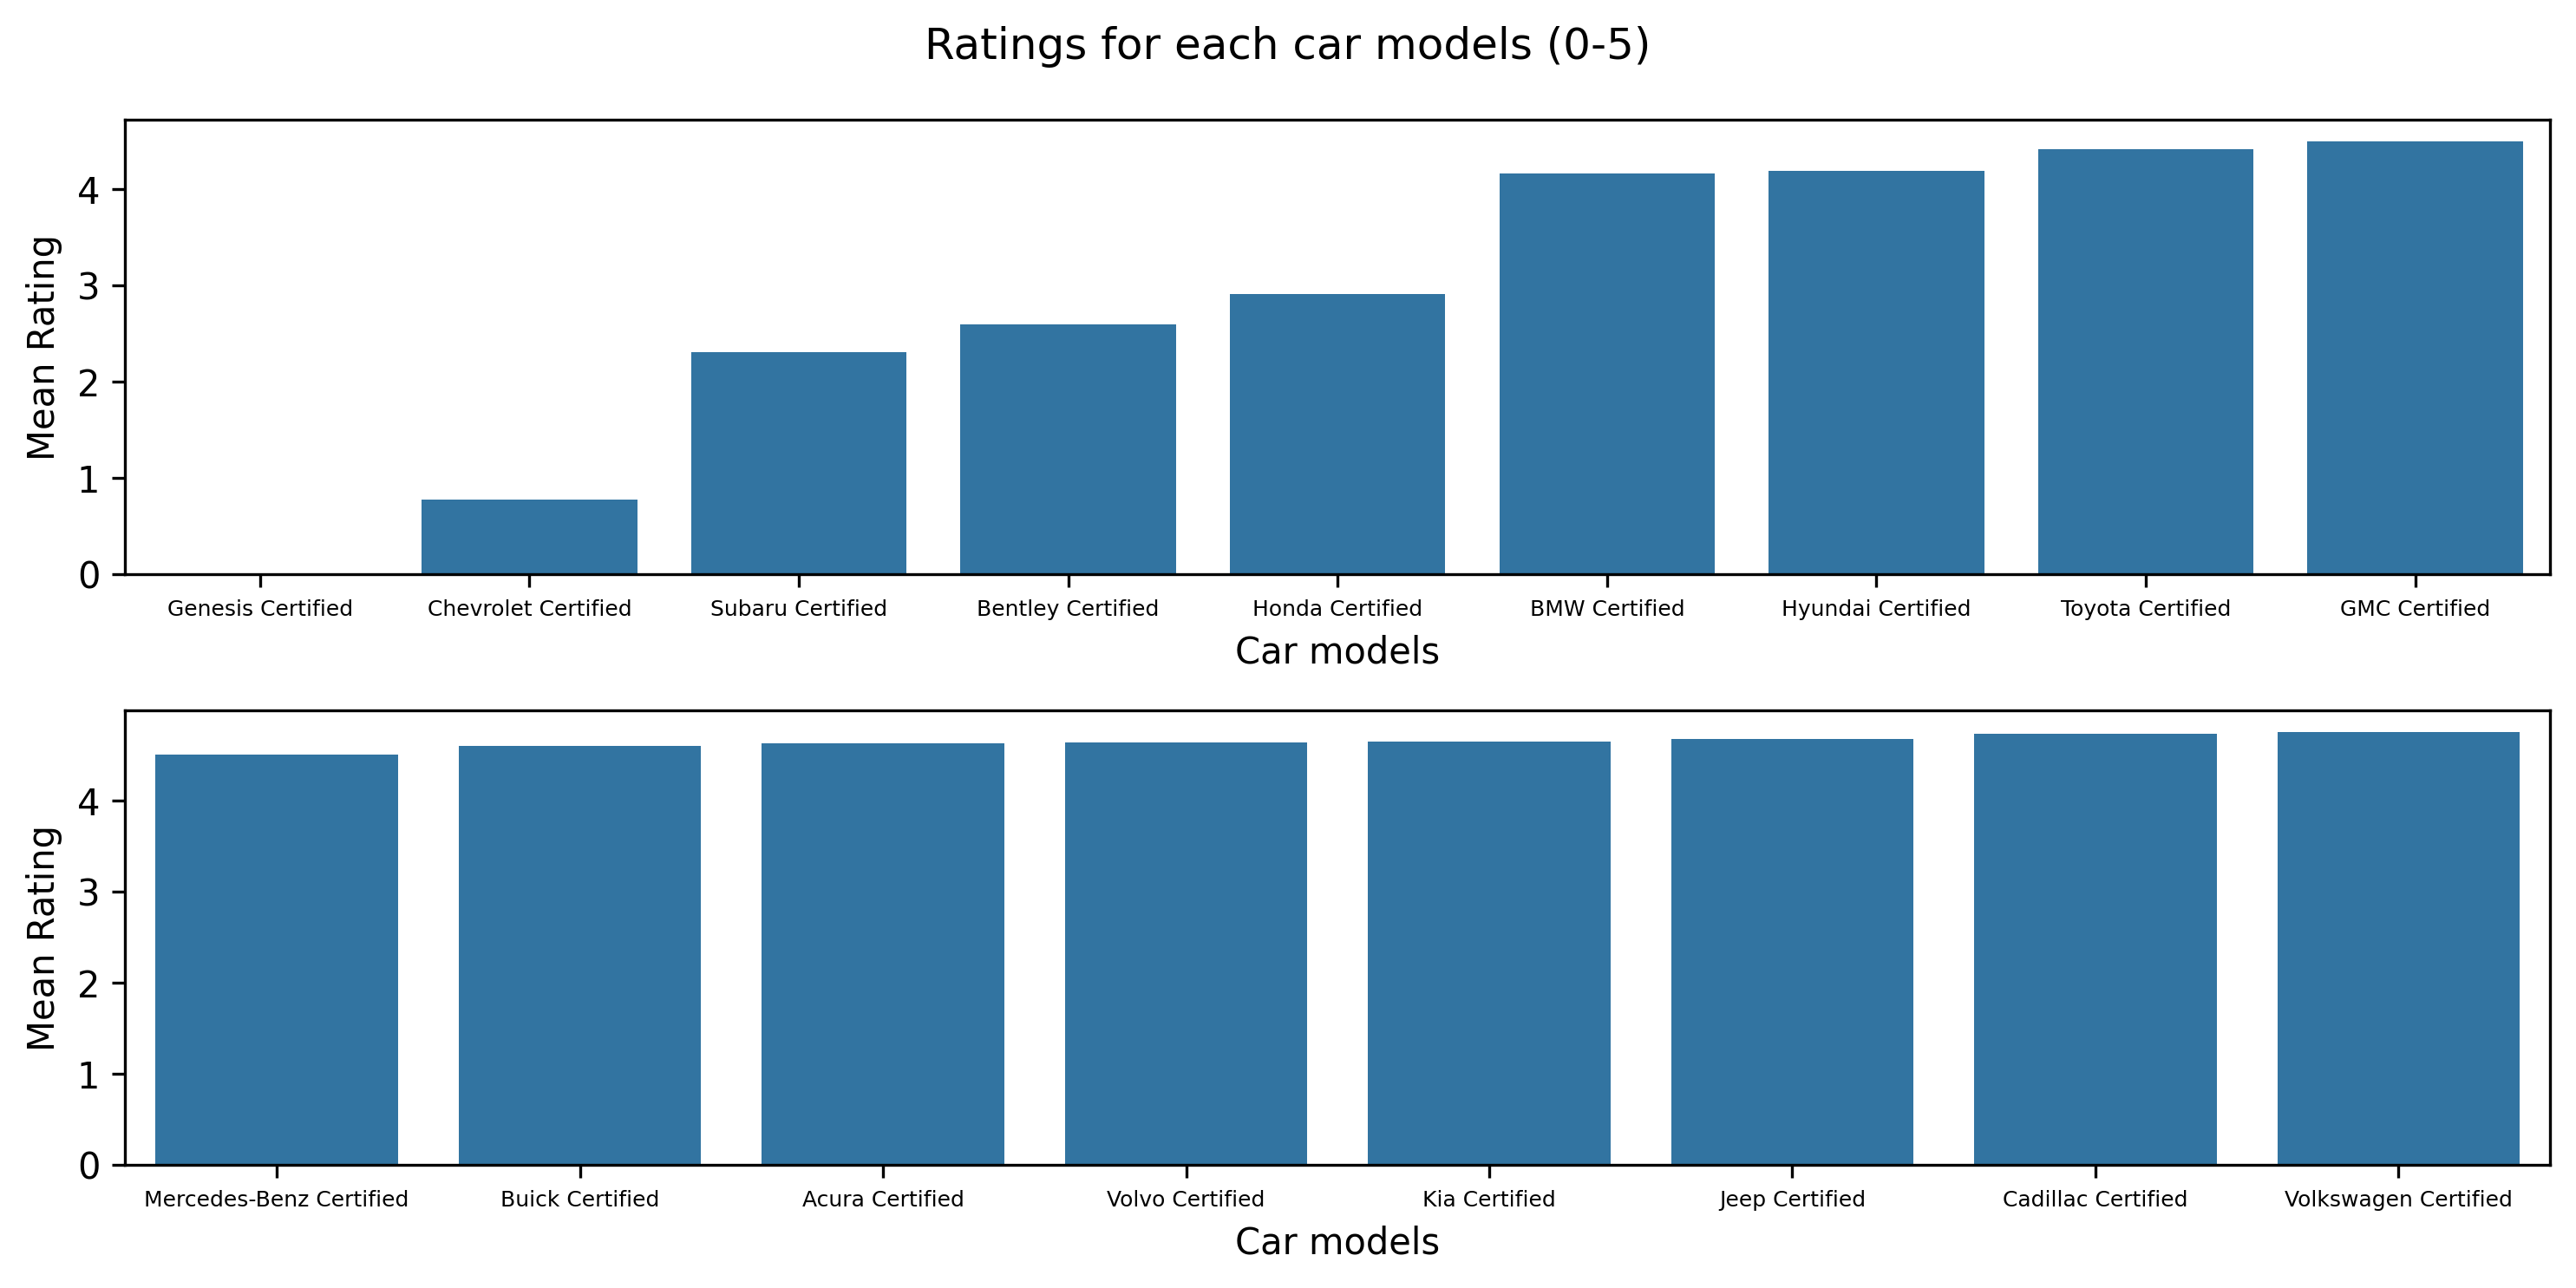

In [112]:
fig, ax = plt.subplots(2)

models = (
    cars.groupby(["Model"])["Rating"]
    .aggregate(["mean"])
    .sort_values(by=["mean"])
    .reset_index()
)

sns.barplot(ax=ax[0], x=models["Model"].iloc[0:9], y=models["mean"])
sns.barplot(ax=ax[1], x=models["Model"].iloc[9:17], y=models["mean"])
fig.suptitle("Ratings for each car models (0-5)")
ax[0].set_ylabel("Mean Rating")
ax[1].set_ylabel("Mean Rating")
ax[0].set_xlabel("Car models")
ax[1].set_xlabel("Car models")
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), fontsize=6)
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), fontsize=6)
fig.tight_layout()
plt.show()

<h5> Specific Price Distribution </h5>

<p> Price distirbution that is classified by deal quality. Porsches and Bentleys have lots of good/great deals that are very expensive. Volvo, and BMW have decently priced cars (not as expensive as Porsche or Bentley) that are great deals. Toyota, Benz, and Volkswagen has mostly "fair" deals but not many great deals compared to other cars. </p>

In [66]:
# fig, axs = plt.subplots(2)
prices = (
    cars.drop(columns=["Name", "Location"])
    .groupby(["Model", "Deals"])
    .mean()[["Price"]]
).reset_index()

prices = prices[prices["Deals"] != "CPO Warrantied"]

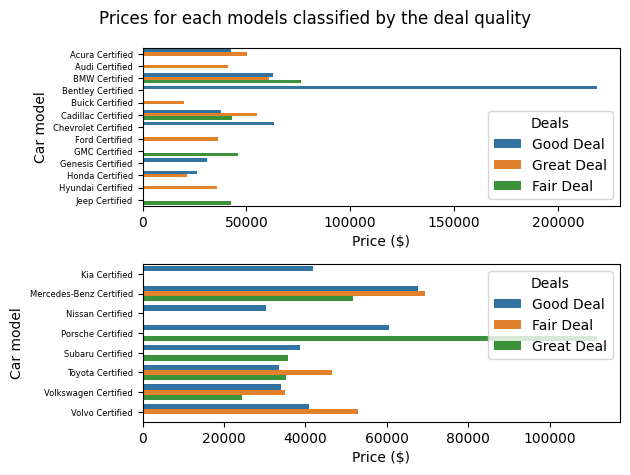

In [67]:
fig,axs = plt.subplots(2)
sns.barplot(
    ax=axs[0],
    data=prices.iloc[0:19],
    x="Price",
    y="Model",
    hue="Deals",
    orient="horizontal"
)
sns.barplot(
    ax=axs[1],
    data=prices.iloc[20:39],
    x="Price",
    y="Model",
    hue="Deals",
    orient="horizontal"
)
fig.suptitle("Prices for each models classified by the deal quality")
axs[0].set_ylabel("Car model")
axs[0].set_yticklabels(axs[0].get_yticklabels(),fontsize=6)
axs[1].set_yticklabels(axs[1].get_yticklabels(),fontsize=6)
axs[1].set_ylabel("Car model")
axs[0].set_xlabel("Price ($)")
axs[1].set_xlabel("Price ($)")
fig.tight_layout()
plt.show()

<h5> Heatmap of numerical variables </h5>

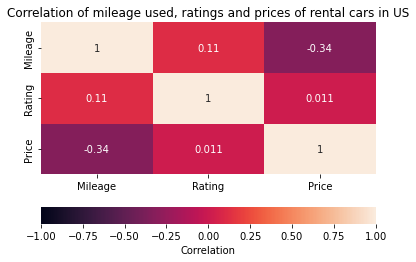

          Mileage    Rating     Price
Mileage  1.000000  0.110947 -0.335054
Rating   0.110947  1.000000  0.011135
Price   -0.335054  0.011135  1.000000


<Figure size 720x360 with 0 Axes>

In [5]:
corr = cars[["Mileage", "Rating", "Price"]]
hm = sns.heatmap(
    corr.corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal"},
)
hm.set_title("Correlation of mileage used, ratings and prices of rental cars in US")
plt.show()
plt.figure(figsize=(10,5))
print(corr.corr())

<h5> Pivot table of Mileage, Price and Ratings of all rentals </h5>
<p> As we mentioned in the above plots, Porsche is sitting at the top with highest price and great deals. Toyota sits at the bottom with the "worst" cars. </p>

In [69]:
ordered_by_price = cars.sort_values(by=["Price"], ascending=True)
cheap_low_mil = ordered_by_price[
    ordered_by_price["Mileage"] == min(ordered_by_price.Mileage)
]
high_mil = ordered_by_price[
    ordered_by_price["Mileage"] == max(ordered_by_price.Mileage)
]
combined = pd.concat([cheap_low_mil, high_mil], ignore_index=True)[
    ["Name", "Rating", "Mileage", "Deals", "Price"]
].reset_index()
combined = combined.pivot(
    index="Name", columns=[], values=["Rating", "Deals", "Mileage", "Price"]
)
print(combined)

                            Rating       Deals Mileage   Price
Name                                                          
2024 Porsche Cayenne S         4.9  Great Deal     817  115996
2024 Porsche Cayenne S         4.9  Great Deal     817  115996
2024 Porsche Cayenne S         4.9  Great Deal     817  115996
2024 Porsche Cayenne S         4.9  Great Deal     817  115996
2024 Porsche Cayenne S         4.9  Great Deal     817  115996
...                            ...         ...     ...     ...
2019 Toyota RAV4 Hybrid XSE    3.9   Good Deal   76930   28389
2019 Toyota RAV4 Hybrid XSE    3.9   Good Deal   76930   28389
2019 Toyota RAV4 Hybrid XSE    3.9   Good Deal   76930   28389
2019 Toyota RAV4 Hybrid XSE    3.9   Good Deal   76930   28389
2019 Toyota RAV4 Hybrid XSE    3.9   Good Deal   76930   28389

[162 rows x 4 columns]


<h5> Regplot of Price vs Mileage and Rating </h5>

<p> Mileage vs Price shows a good linear relationship while Rating vs Price is not so linear. We will use ML to check for more relationships later.</p>

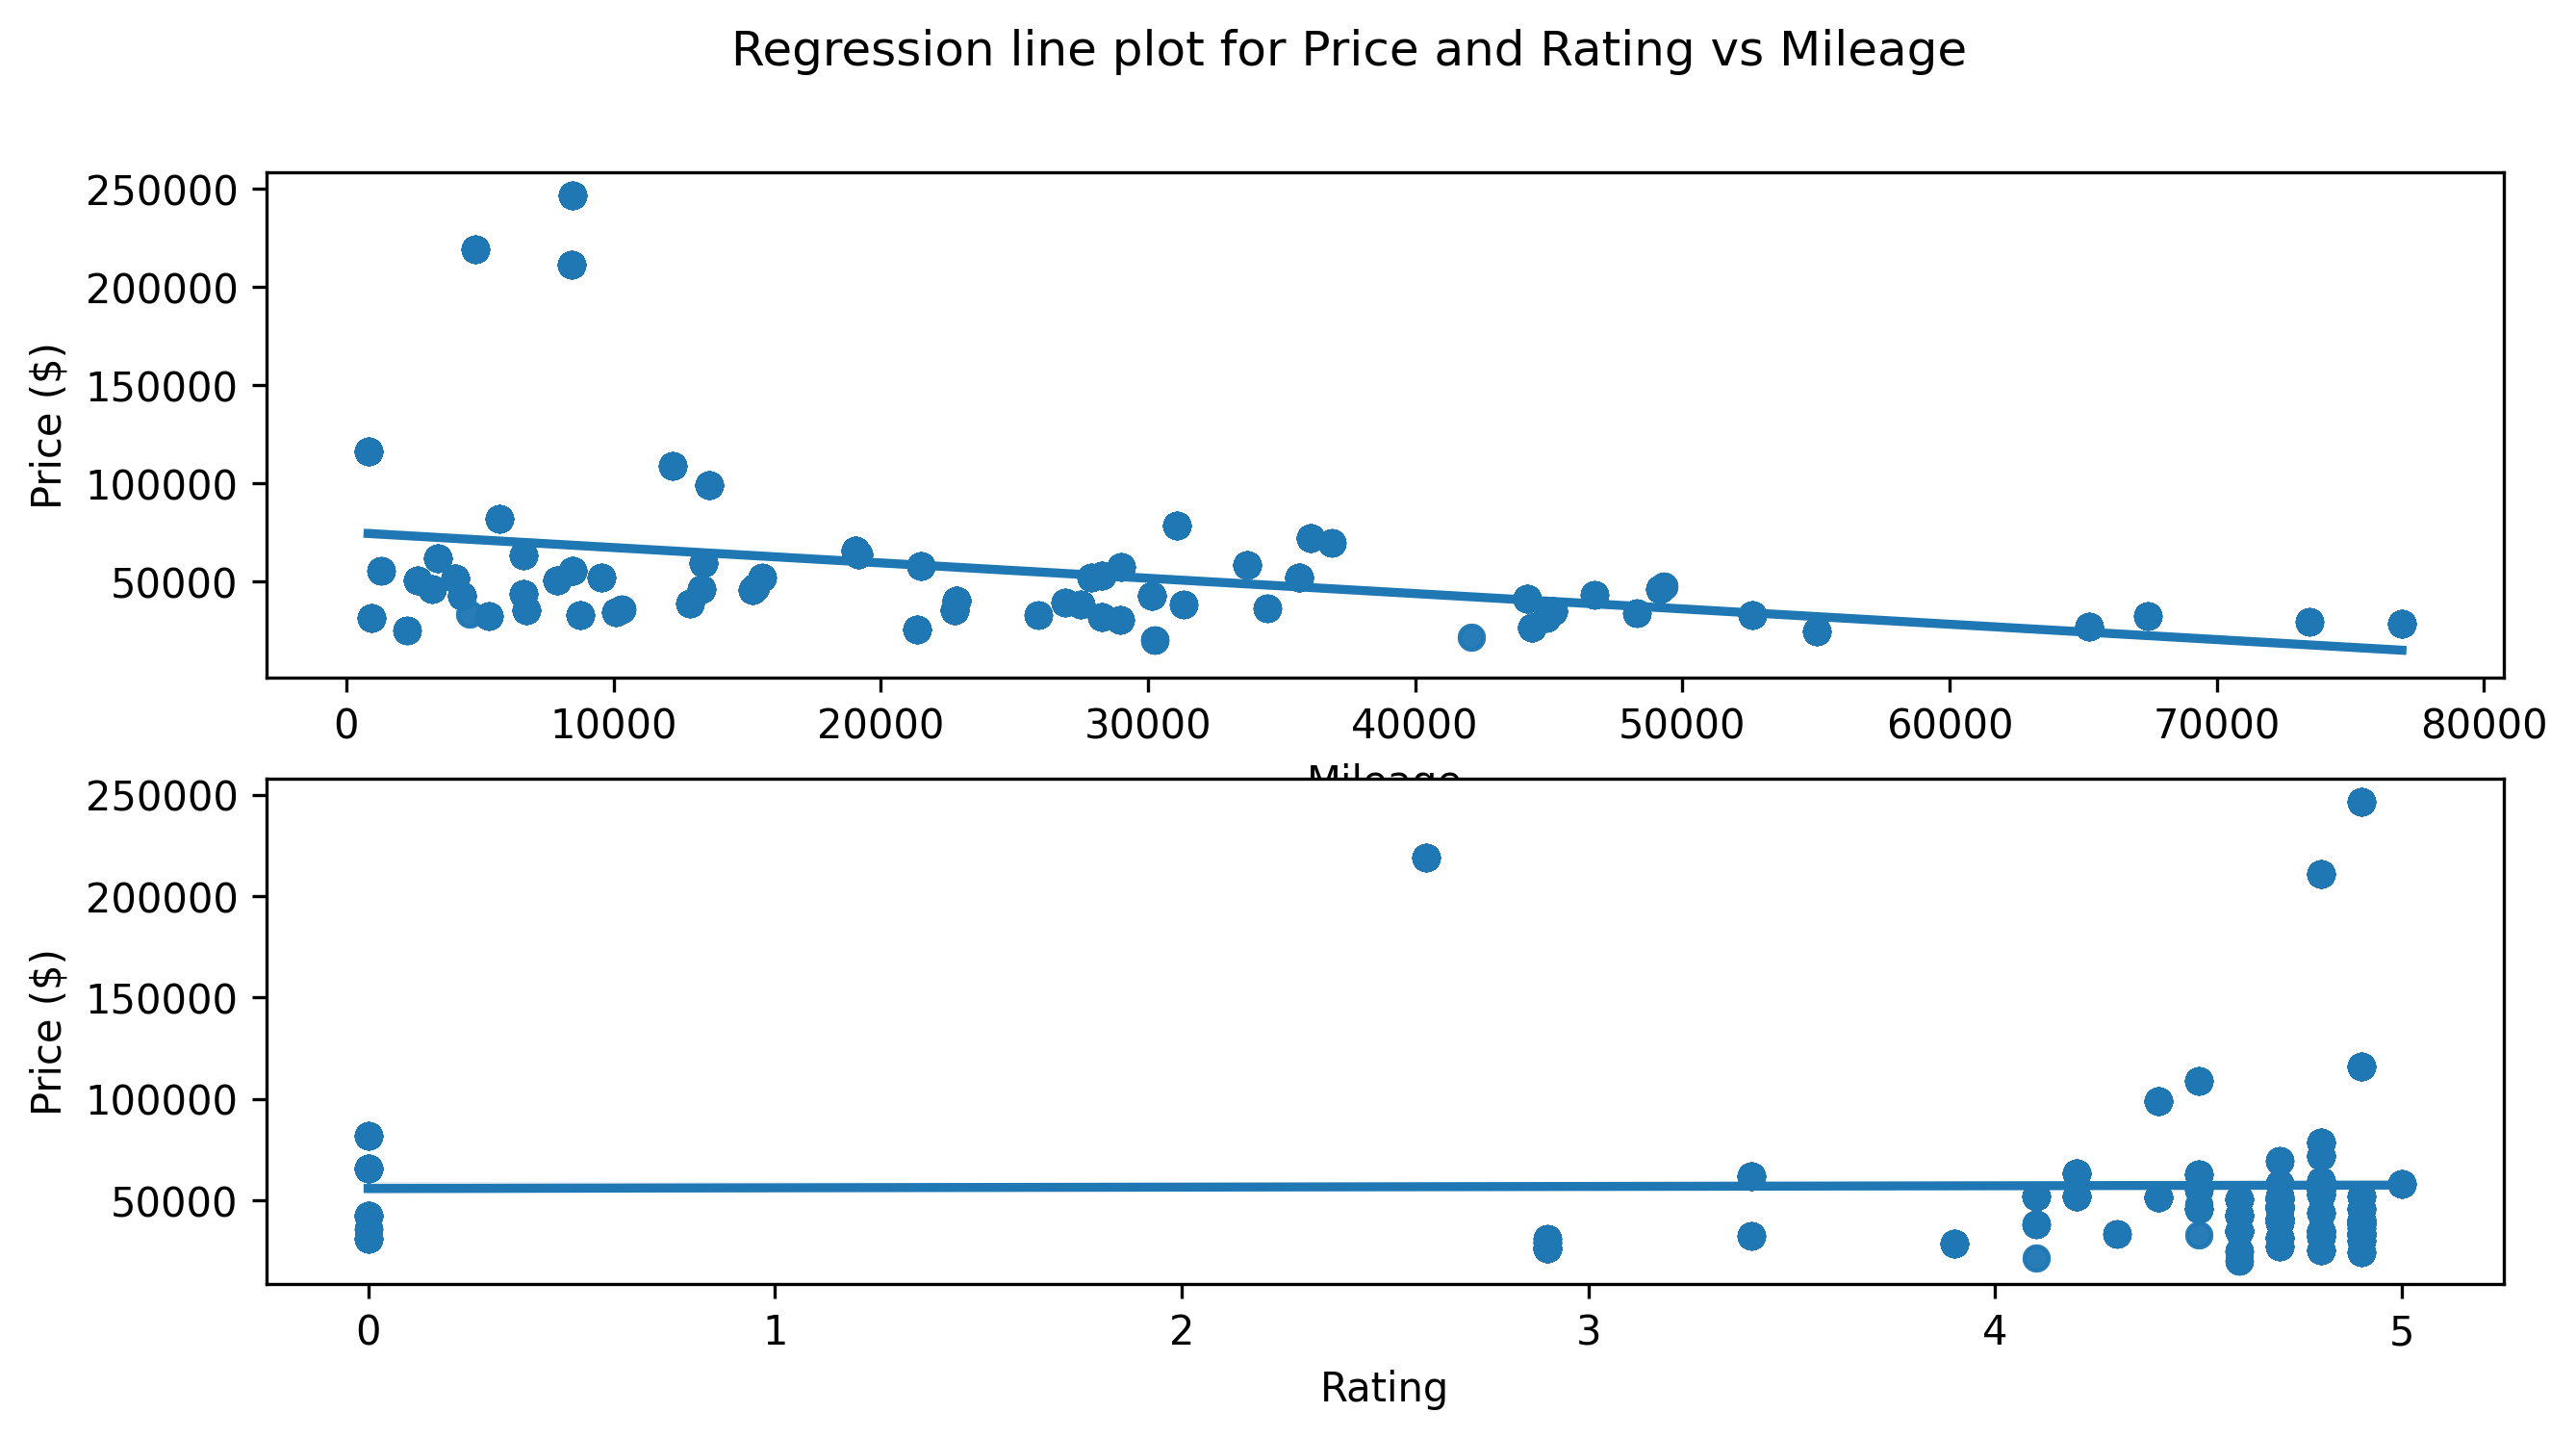

In [114]:
# 4. regression plot of mileage
fig, ax = plt.subplots(2)
vars = ["Mileage", "Rating"]
for i, v in enumerate(vars):
    sns.regplot(data=cars, x=v, y="Price", ax=ax[i])
fig.suptitle("Regression line plot for Price and Rating vs Mileage")
ax[0].set_ylabel("Price ($)")
ax[1].set_ylabel("Price ($)")
plt.show()

<h5> Simple Boxplot of reviews cars with certain deal-quality </h5>

<p> There is no definite relationship here between deal-quality and reviews it receives. It certainly must be other factors that controls popularity. </p>

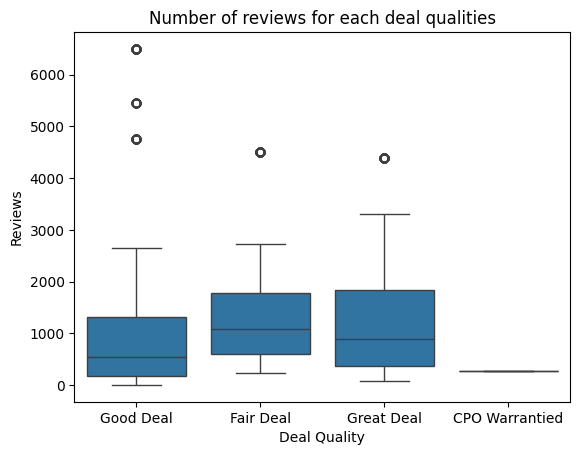

In [70]:
box = sns.boxplot(data=cars, x="Deals", y="Reviews")
box.set(xlabel="Deal Quality", title="Number of reviews for each deal qualities")
plt.show()

<h5> Jointplot of Price Change vs Reviews </h5>

<p> It is somewhat plausible to say that the number of reviews is only very high for prices changes that are on the lower-end. Through research, cars with less price change are more likely to be very consistent and common cars (not Bentley or Benz). Hence, it makes sense for those cars to be more popular, as more people will look forward to getting an efficient deal! </p>

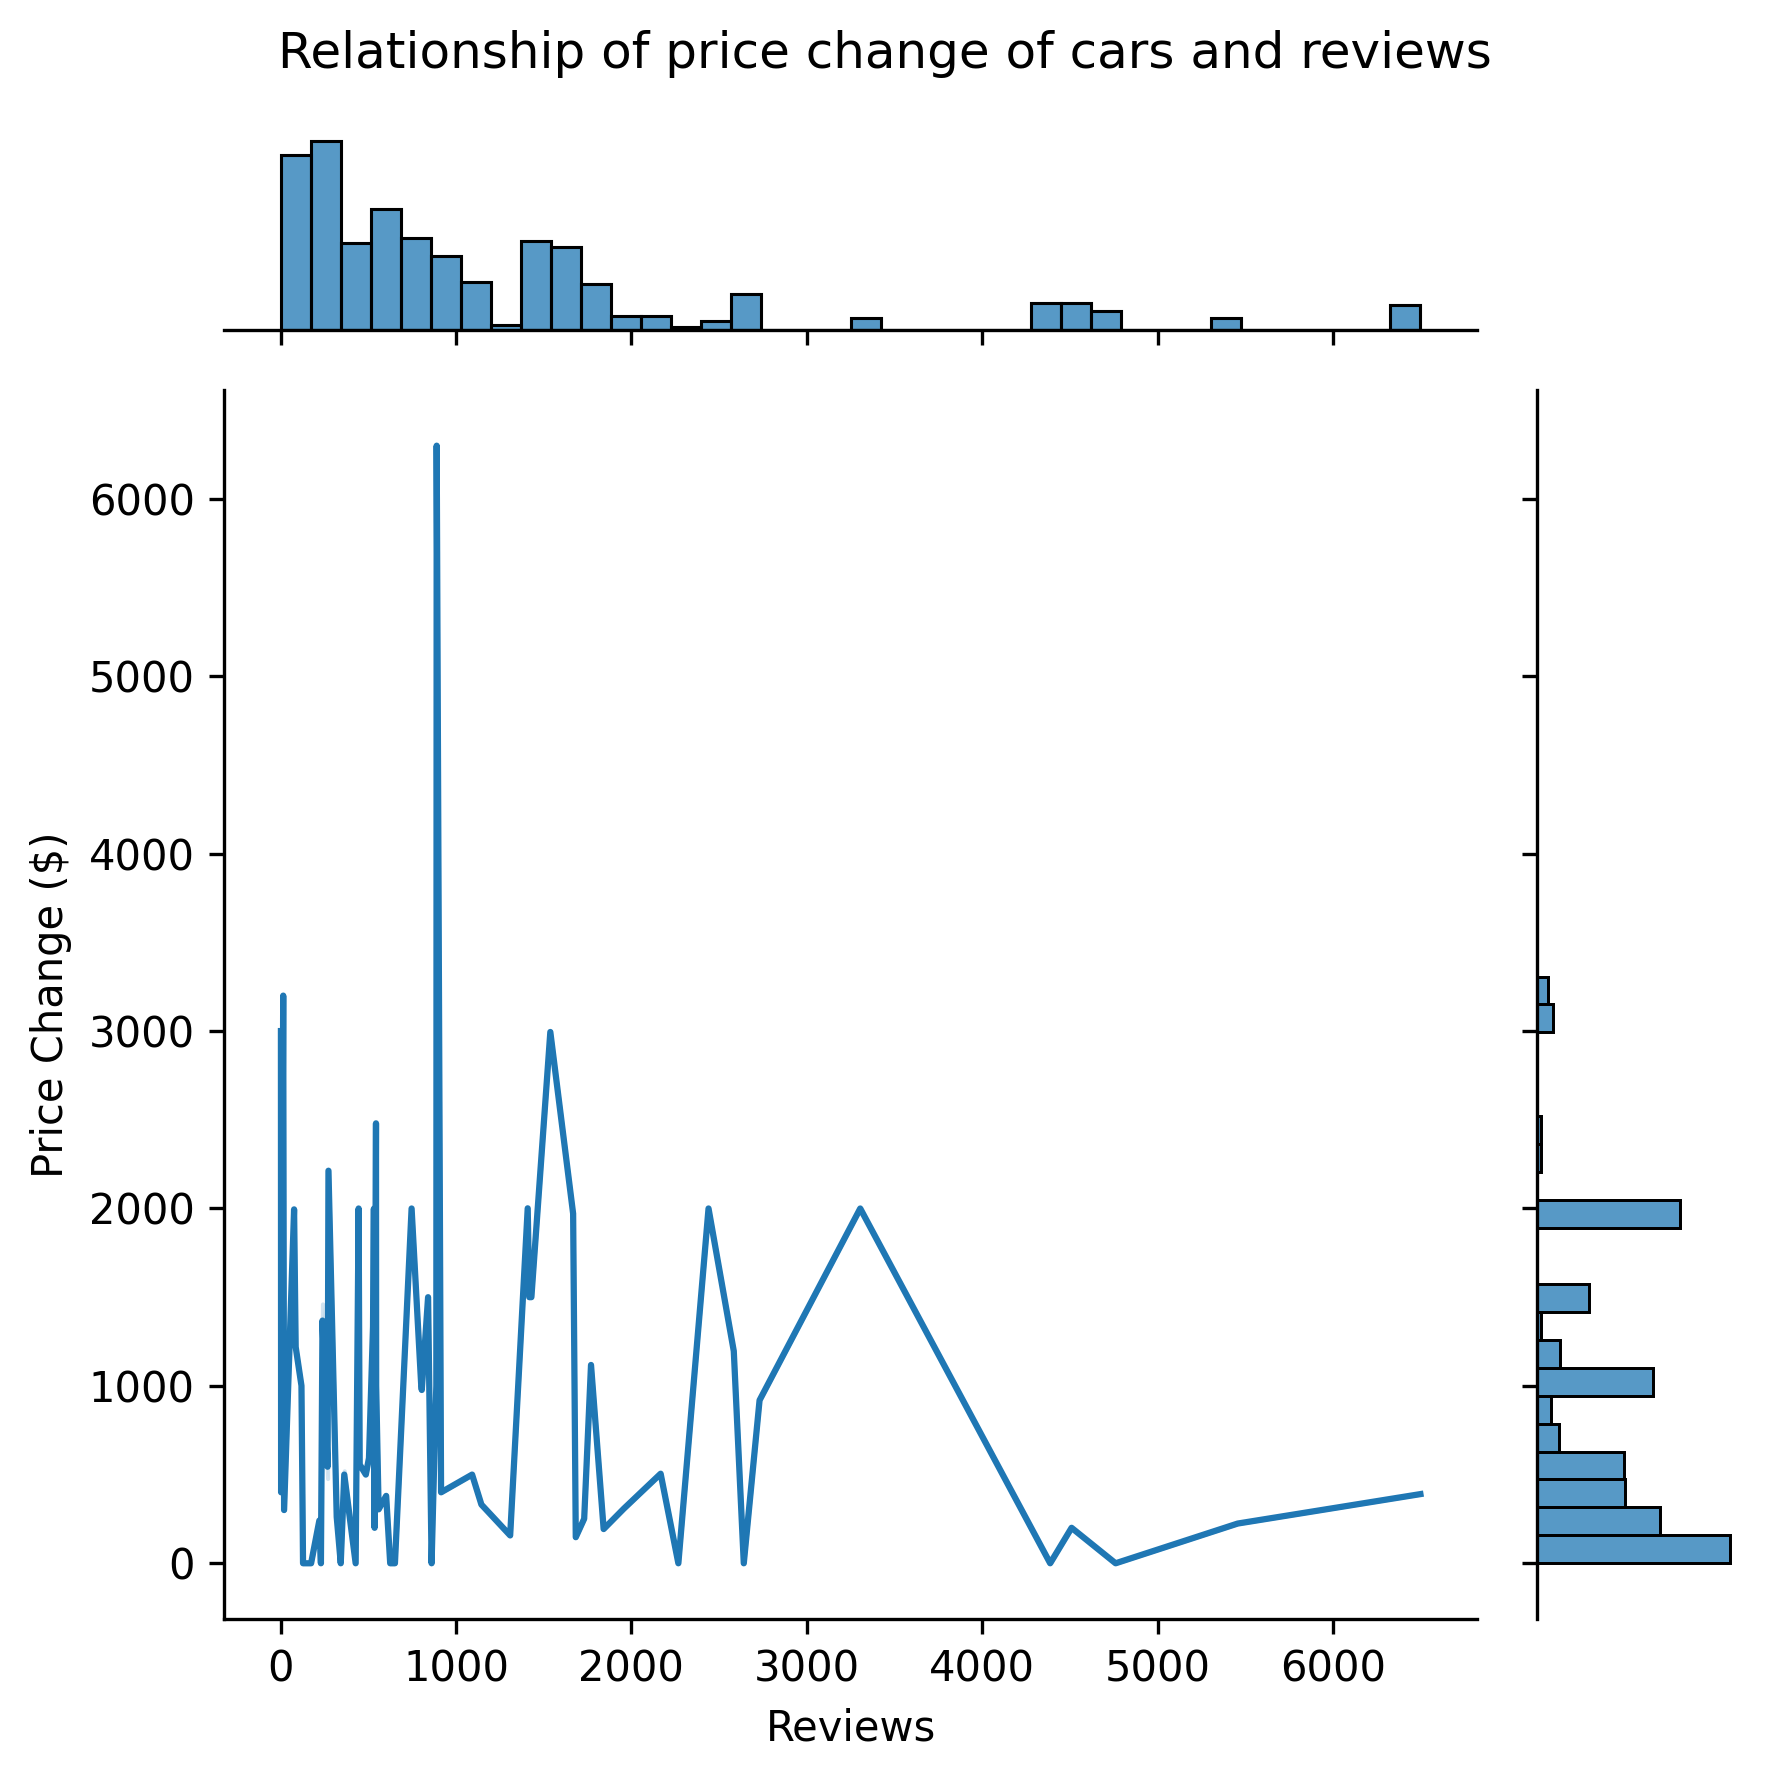

In [120]:
jg = sns.JointGrid(data=cars, x="Reviews", y="Price_change")
jg.plot(sns.lineplot, sns.histplot)
jg.set_axis_labels("Reviews","Price Change ($)")
jg.fig.suptitle("Relationship of price change of cars and reviews")
plt.tight_layout()
plt.show()

<h5> Descriptive statistics for each locations </h5>

<p> The table below may provide very good summary of each states. Hence, when travelling to different states, it is helpful to generalize some characteristics beforehand to know how much money you have to invest into cars. The state "MD" has very pricey, new cars compared to very cheap and old cars "KY". When travelling to Maryland, customers should be cautious of their budget. </p>

In [94]:
def get_states(x):
    return str(x).split(", ")[1]

cars["Location"] = cars["Location"].apply(get_states)
d = cars.groupby(["Location"]).mean(numeric_only=True).reset_index()

def count(i):
    c = 0
    for j in cars["Location"]:
        if str(j) == str(i):
            c += 1
    return c


d["Cars_from"] = [count(i) for i in d["Location"]]
d = d.sort_values(by=["Rating"], ascending=False).drop(columns=["id"])
d=d[d["Cars_from"]>1].reset_index()
print(d.drop(columns=["index"]))

   Location          Price    Rating      Reviews       Mileage  Price_change  \
0        MS   36139.000000  4.900000   126.000000  34483.000000    231.000000   
1        MD  113846.068182  4.881818   123.568182   1755.250000    984.181818   
2        TX   31995.000000  4.800000   428.000000   5333.000000      0.000000   
3        GA   46008.621262  4.800000   651.378738  15954.970100   1108.584718   
4        IN   91091.800725  4.800000   210.681159  15849.452899    269.304348   
5        RI   71988.000000  4.800000   747.000000  36093.000000   2000.000000   
6        VA   37988.063348  4.781900  1284.208145  16494.683258   1410.108597   
7        MA   45179.545455  4.700000  1227.575758  26411.575758    838.439394   
8        CO   38692.095238  4.635374  3048.734694  33881.074830    134.421769   
9        CA   92657.433649  4.597156  1049.616114  19637.199052   1047.772512   
10       AZ   62195.490066  4.573510   411.331126  31357.761589    728.476821   
11       WI   41621.711443  

<h5> Section 6 Plot </h5>

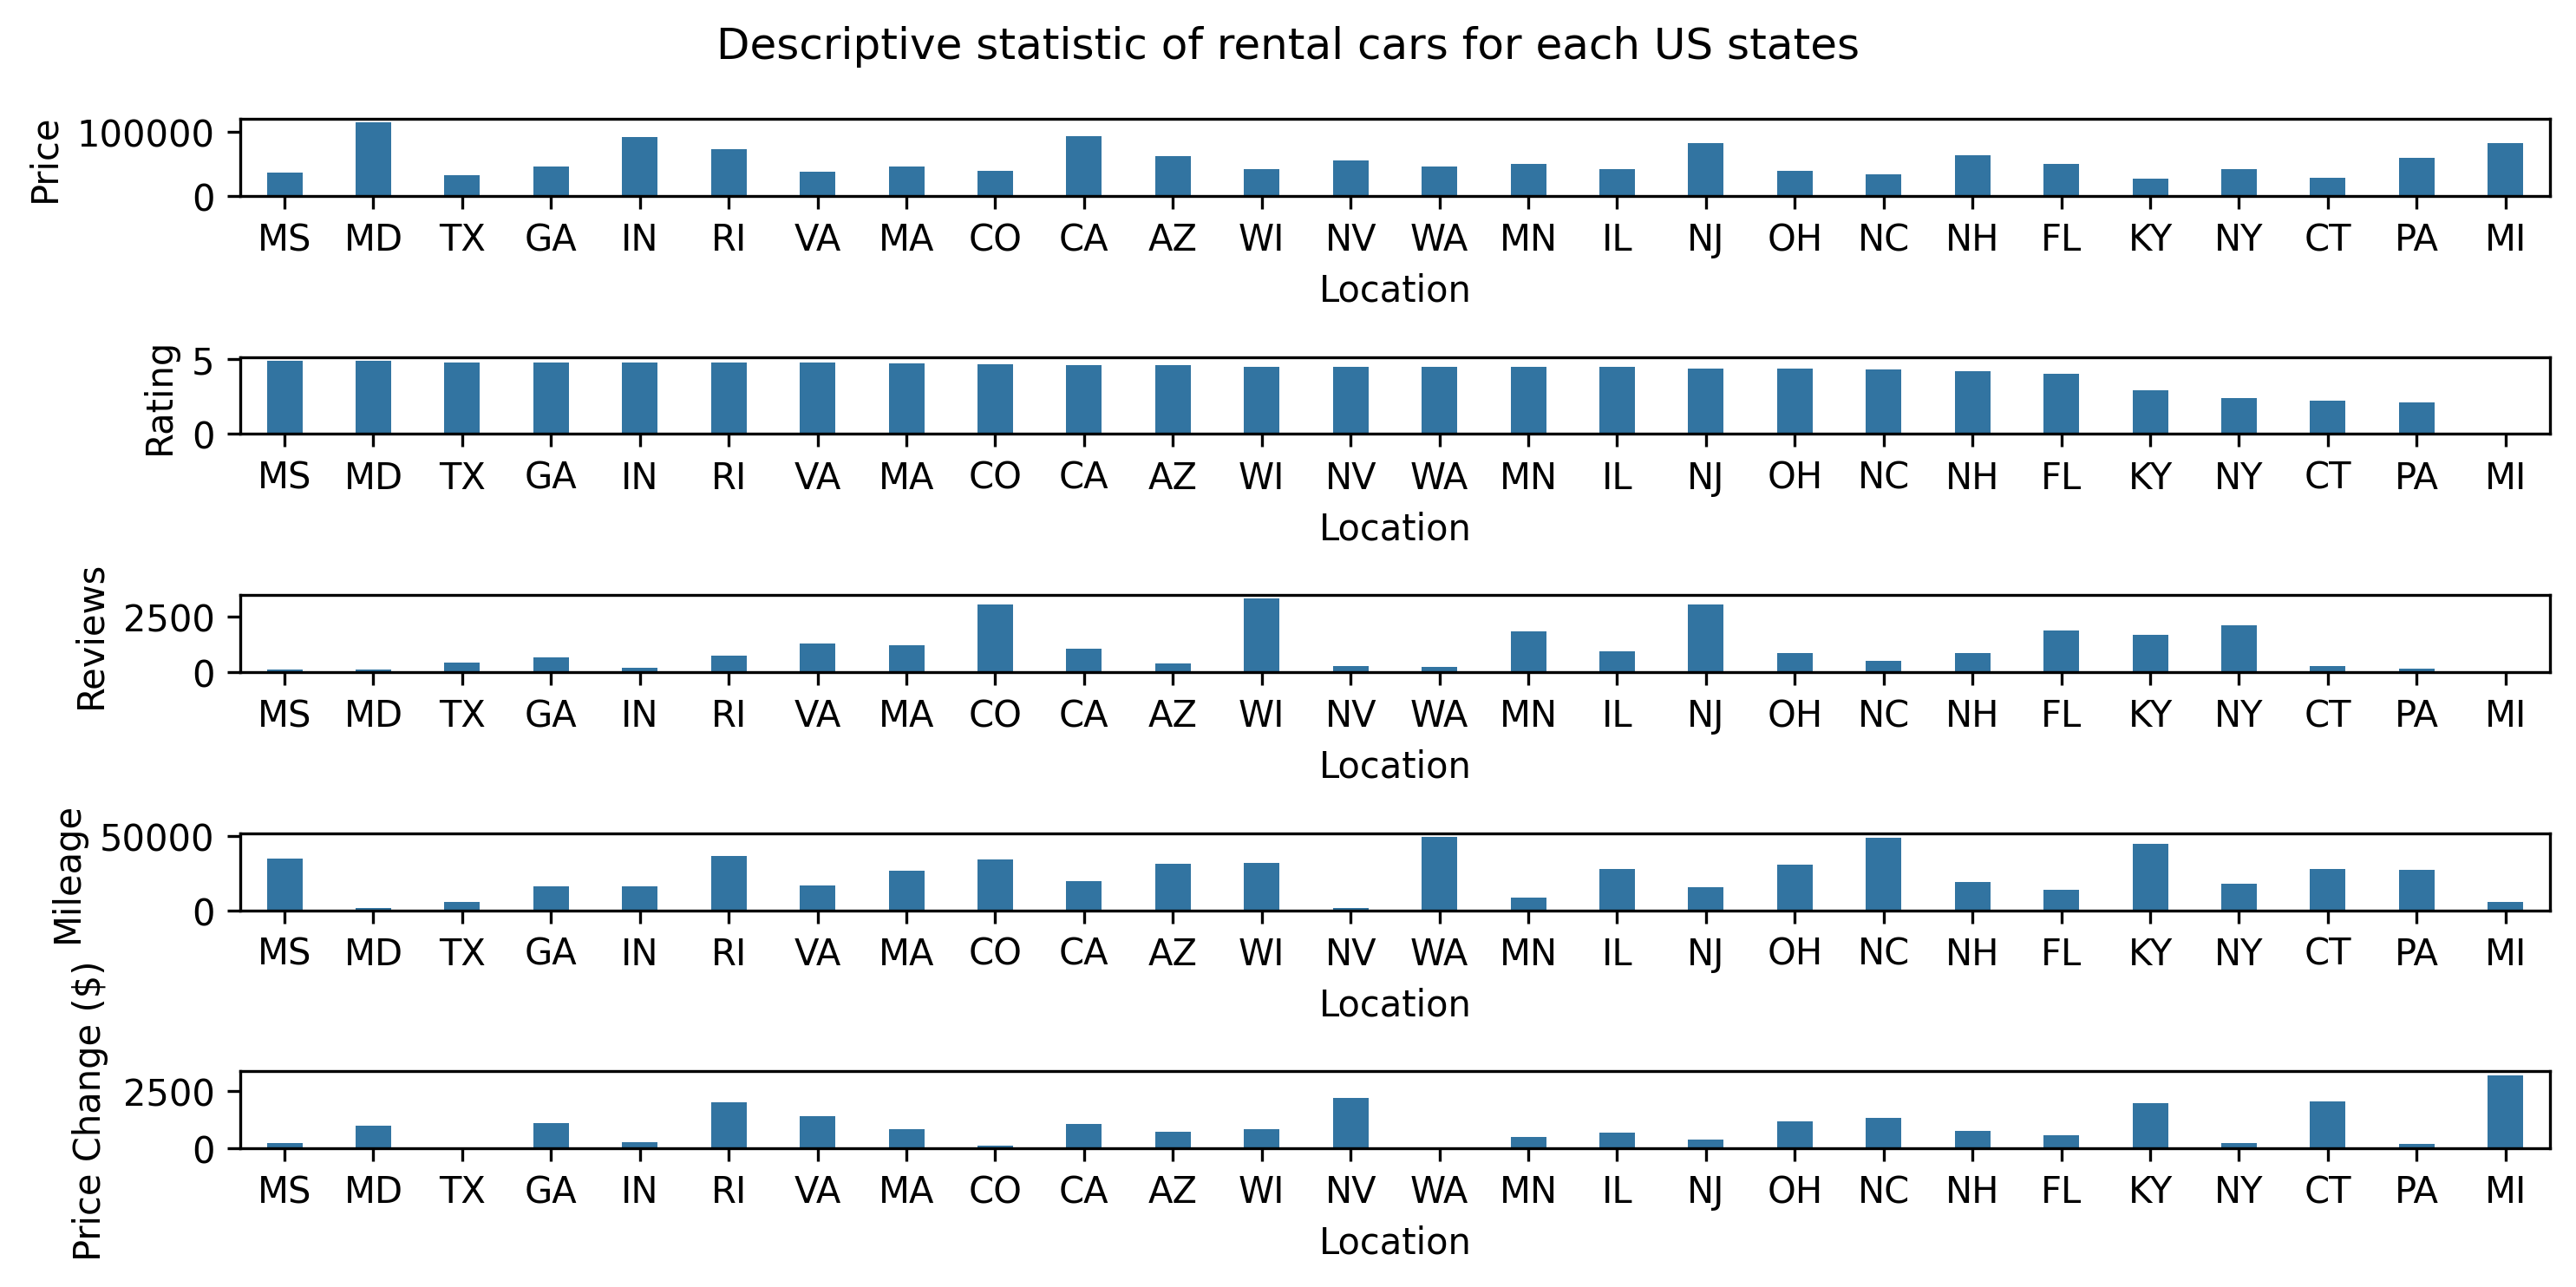

In [96]:
figs,axs = plt.subplots(5)
cats = ["Price", "Rating", "Reviews", "Mileage","Price_change"]
for i in range(0,5):
    sns.barplot(data=d, x="Location", y=cats[i], ax=axs[i], gap=0.5)
figs.suptitle("Descriptive statistic of rental cars for each US states")
axs[4].set_ylabel("Price Change ($)")
figs.tight_layout()
plt.show()

<h2> Choosing the right ML regression model: How is Price of cars affected by other factors? </h2>

<h5> Data Pre-processing </h5>

<p> Since we are focusing on regression, we are dropping all categorical datas from the dataset. X will act as our features and y will be our responsive variable set. </p>

In [97]:
cars = pd.read_csv("./car_deals.csv", sep=",")
X = cars.drop(columns=["id", "Location", "Name", "Model", "Deals", "Price", "Mileage"])
y = cars[["Price"]]

print(X.shape)
print(y.shape)

(4200, 3)
(4200, 1)


Using train_test_split() function from the sci-kit library, we can split the training set and test set with a test-set ratio of 0.1 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

<h5> Finding the right factors </h5>

We will use the SelectKBest() algorithm and the chi-squared scoring function to find the columns that are NOT colinear with Price variable and overall has a decent relationship to perform regression. The Chi-squared function tests whether or not variables are dependent and selects the ones that are not. Dependent variables can cause bias in our results/accuracy.

In [99]:
threshold = 2
skb = SelectKBest(score_func=chi2, k=threshold).fit(X,y)
sel_skb = skb.fit(X_train, y_train)
sel_skb_index = sel_skb.get_support()
best_features = X_train.iloc[:, sel_skb_index]
print('p_values', sel_skb.pvalues_)
print(best_features.columns)

p_values [5.10676851e-295 0.00000000e+000 0.00000000e+000]
Index(['Reviews', 'Price_change'], dtype='object')


<h5> Finding the best models using GridSearchCV </h5>

The list model_info contains dictionaries of various models and the range of parameters to test for the corresponding models. We will feed this list into the GridSearch function in a loop to test which model -- tested with the given range of parameters -- outputs the highest accuracy.

Models included: 
* Linear regression
* Random Forest regression
* Lasso regression
* Ridge regression

In [100]:
model_info = [
    {"model": LinearRegression(fit_intercept=True), "name": "lm", "params": {}},
    {
        "model": RandomForestRegressor(),
        "name": "rfr",
        "params": {
            "n_estimators": [i for i in range(0, 7)],
        },
    },
    
    {
        "model": Lasso(fit_intercept=True),
        "name": "lasso",
        "params": {"alpha": [0.001, 0.01, 0.5, 0.8, 1, 1.5, 2]},
    },
    {
        "model": Ridge(fit_intercept=True),
        "name": "ridge",
        "params": {"alpha": [0.001, 0.01, 0.5, 0.8, 1, 1.5, 2]},
    }
]

The run_grid_search() function allows us to iterate over and run GridSearch algorithm. It implements a simple for-loop which iterates items and fits our training dataset that we splitted and records the best score for each model. Then, we can compare each scores of the models.

In [101]:
def run_grid_search(m):
    # TODO
    res = []
    for item in m:
        model_name = item["model"]
        param = item["params"]
        name = item["name"]
        gs = GridSearchCV(
            estimator=model_name, param_grid=param, cv=5, return_train_score=True
        )

        g = gs.fit(X_train, y_train)
        res.append(
            {
                "name": name,
                "result": g.cv_results_,
                "result_2": g.best_estimator_,
                "score": g.best_score_,
            }
        )

    return res

Finally, we create a dataframe to store all the results fromm gridsearching.

In [102]:
result = run_grid_search(model_info)
result_df = pd.DataFrame()
result_df["Model"] = [i["name"] for i in result]
result_df["Score"] = [i["score"] for i in result]
print(result_df)

   Model     Score
0     lm  0.041988
1    rfr  0.999832
2  lasso  0.041988
3  ridge  0.041988


We clearly see that the Random forest regressor outputs the highest score, while other models do not seem to be able to fit the training data correctly given the indepedent variables: Reviews and Price_change. Hence, we should use the RandomForestRegressor() to finalize our results for this project. However, it wouldn't be a bad idea to test out other variables as well due to the fact that the score is VERY close to 1. This isn't bad however, given that our variables are completely independent, getting an almost 100% accurate prediction is skeptical.

<h5> Using Random forest regression and assessing its results <h5>

In [127]:
best = RandomForestRegressor()
fitted_1 = best.fit(X_train, y_train)
res_1 = fitted_1.predict(X_train)
score_1 = best.score(X, y)

In [128]:
r21 = r2_score(y_train, res_1)
mse1 = mean_squared_error(y_train, res_1)
mae1 = mean_absolute_error(y_train, res_1)

metrics = pd.DataFrame(
    {
        "Metrics": ["Overall Score", "R2", "Mean Squared Error", "Mean Absolute Error"],
        "RF": [score_1, r21, mse1, mae1]
    }
)

In [129]:
print(metrics)

               Metrics            RF
0        Overall Score      0.999992
1                   R2      0.999991
2   Mean Squared Error  14864.028415
3  Mean Absolute Error      4.119320


<h2> Conclusion </h2>

Overall, our results using the Random Forest regression is nearly perfect with the computed R^2 score of 99.99% (0.9999~). The computed MSE seems to be too high which is something to be skeptical about given that our R^2 is extremely high. The MAE, which is more robust to outliers, is somewhat low which makes sense as R^2 indicates a very good prediction by the model. Again, because of the extremely high R^2, it is reasonable to try out other alternative variables to test for regression. The model could be overfitting the data or could be an inherent problem with the training set, and this must be a future question to consider for any future studies.

Generally, out of the 4 models, Random forest is currently the best one. However, through experimentation, we see that the result differs for differnt variables. It is critical that optimization such as GridSearch or RandomizedSearch is implemented for every ML projects/research so that one can explore all possible outcomes. For this project, a possible improvement would be implementing more models to test.

Finally, it is almost clear that one can predict prices of rental cars well with Random Forest but also recognize that it may not be perfect. Based on the EDA section of this work, JEEP, GMC, and BMW are the 3 highly recommended cars most of the cars being considered as great-deals and the price is not too bad compared to others! 

<h2> References </h2>

* Suhas Maddali, Medium, (May 10th, 2022), Predicting Car Prices Using Machine Learning and Data Science: https://medium.com/odscjournal/predicting-car-prices-using-machine-learning-and-data-science-52ed44abab1b
* Sruthi E. R, Analytics Vidhya, (January 3rd, 2024), Understand Random Forest Algorithms: https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/
* Stefan Labbe, north shore News, (May 7th, 2022), Pandemic paves way for new car-share programs: https://www.nsnews.com/local-news/pandemic-paves-way-for-new-bc-car-share-programs-including-renting-out-your-vehicle-5336767
* Kathryn Folliot, travelweek, (July 20th, 2023), Rate hikes up for rental cars: https://www.travelweek.ca/news/rate-hikes-of-up-to-5-for-rental-cars-in-canada-and-the-u-s-amex-gbt-report/#:~:text=Travelweek%3A%20Amex%20GBT's%20Ground%20Monitor,couple%20of%20years%20of%20shortages!
* Enis Gegic, Becir Isakovic, Dino Keco, Zerina Masetic, Jasmin Kevric, TEM Journal, (February, 2019), Car Price Prediction using Machine
Learning Techniques: https://www.temjournal.com/content/81/TEMJournalFebruary2019_113_118.pdf
